# Demo ARIMA Time Series Forecasting on Ray local

### Description:  
This notebook goes along with the tutorial <a href="https://towardsdatascience.com/scaling-time-series-forecasting-with-ray-arima-and-prophet-e6c856e605ee">How to Train Faster Time Series Forecasting Using Ray, part 1 of 2<a>.

This notebook demonstrates Time Series Forecasting ARIMA algorithm on Ray.  Example data is NYC yellow taxi from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page  <br>

Forecast goal:  Given 6 months historical taxi trips data for NYC, your task is to predict #pickups at each location in NYC at monthly level for the next 2 months.

### Demo notes:
Output shows timings using SMALL dataset <br>
Both demo datasets are available in this github repo under data/  <br>
SMALL dataset contains original, actual 260 items "clean_taxi_monthly.parquet" <br>
MEDIUM dataset contains 2860 items with extra fakes "clean_taxi_monthly_fake_medium.parquet" <br>

In [1]:
!python --version
import time, os
from typing import Tuple
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
# Import forecasting libraries.
import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")

Python 3.8.13
Number of CPUs in this system: 8


/Users/christy/opt/miniconda3/envs/prophet38/lib/python3.8/site-packages/statsforecast/core.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


statsforecast: 1.3.1


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-08 16:17:37,462	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [3]:
print(ray.cluster_resources())

{'CPU': 8.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 8680770765.0}


# Read 8 months clean NYC taxi data 

New York City Yellow Taxi ride volumes per location (8 months of historical data). <ul>
    <li>Original source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</li>
    <li>Clean monthly source:  https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly.parquet?raw=true </li>
    </ul>

Normally there is a data cleaning/prep step to convert raw data -> cleaned data.  We'll dig into details of ETL later.  <br>
For now, let's just start with cleaned, aggregated monthly data for ARIMA and Prophet, since those algorithms are typically for strategic-level forecasting, not typically for detailed-level forecasting.

In [4]:
##########
## STEP 1.  Read data and ray.put() data into Ray shared cluster memory.
##########
# Read data into a Pandas dataframe.
filename = "../../../forecasting_demos/Ray_v1/data/clean_taxi_monthly.parquet"
g_month = pd.read_parquet(filename)

# Prophet requires timstamp is 'ds' and target_value name is 'y'
# Prophet requires at least 2 data points per timestamp
# StatsForecast requires location name is 'unique_id'

g_month.reset_index(inplace=True)
g_month.rename(columns={"pickup_monthly": "ds"}, inplace=True)
g_month.rename(columns={"pulocationid": "unique_id"}, inplace=True)
g_month.rename(columns={"trip_quantity": "y"}, inplace=True)
g_month.drop(['pickup_lat', 'pickup_lon'], axis=1, inplace=True)

# Put data in shared ray object store.
input_data_ref = ray.put(g_month)

display(g_month.head())


,ds,unique_id,y
0,2019-07-31,1,50
1,2019-07-31,10,2201
2,2019-07-31,100,138614
3,2019-07-31,101,63
4,2019-07-31,102,97


In [5]:
# Define some global variables.
TARGET = "trip_quantity"
FORECAST_LENGTH = 2
UNIQUE_ID="unique_id"
ID_LIST = list(g_month[UNIQUE_ID].unique())

try:
    # drop [264, 265, 199]
    ID_LIST.remove(264)
    ID_LIST.remove(265)
    ID_LIST.remove(199)
except:
    print("Problem locations already removed.")

Problem locations already removed.


# Regular Python

In [6]:
# Define a train_model function.
def train_model_arima(
    input_df:pd.DataFrame, 
    input_value:str
) -> Tuple[pd.DataFrame, pd.DataFrame, bytes]:
    
    # Hide noisy warnings.
    import warnings
    warnings.filterwarnings("ignore")
    
    # Subset pandas df
    df = input_df.loc[(input_df[UNIQUE_ID] == input_value), :].copy()

    # Split data into train, test.
    train_end = df.ds.max() - relativedelta(months=FORECAST_LENGTH - 1)
    train_df = df.loc[(df.ds <= train_end), :].copy()
    test_df = df.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define ARIMA model with monthly frequency which implies seasonality = 12.
    model = [AutoARIMA(season_length=12, approximation=True)]      

    # Train and fit AutoARIMA model.
    model = StatsForecast(df=train_df, models=model, freq="M")
    
    return train_df, test_df, model


# Define inference_model function
def inference_model_arima(model:'statsforecast.core._StatsForecast', 
                          test_df:pd.DataFrame
                         ) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecast = model.forecast(FORECAST_LENGTH).reset_index()
    forecast.set_index(["ds"], inplace=True)
    test_df.set_index("ds", inplace=True)
    future = pd.concat([test_df, forecast[["AutoARIMA"]]], axis=1)
    future.dropna(inplace=True)
    future.columns = [UNIQUE_ID, "y", "yhat"]

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    error = np.mean(temp["forecast_error"])

    return error, future

# Test regular python functions

In [7]:
%%capture
# hide noisy output

###########
# Regular Python program flow to train and inference ARIMA models
###########
model = []
train = []
valid = []
forecast_obj_refs = []

# Train every model.
start = time.time()
train, valid, model = map(
    list,
    zip(
        *(
            [
                train_model_arima(
                    g_month,
                    input_value=v,
                )
                for v in ID_LIST
            ]
        )
    ),
)

# Inference every model.
error, forecast = map(
    list,
    zip(
        *(
            [
                inference_model_arima(model[p], valid[p] )
                for p in range(len(ID_LIST))
            ]
        )
    ),
)

# Print some training stats
time_regular_python = time.time() - start
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")


### Inspect a few forecasts

Total number of models: 260
TOTAL TIME TAKEN: 0.16 minutes


,unique_id,y,yhat
ds,,,
2020-01-31,1,34,52.351261
2020-02-29,1,35,51.710461


,unique_id,y,yhat
ds,,,
2020-01-31,10,1689,1890.360107
2020-02-29,10,1386,1881.759399


<Figure size 800x500 with 0 Axes>

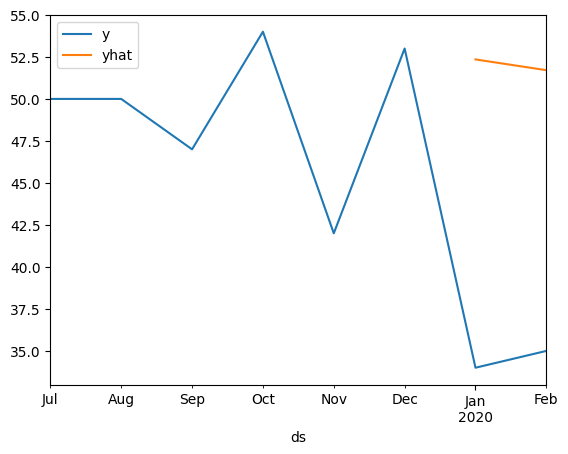

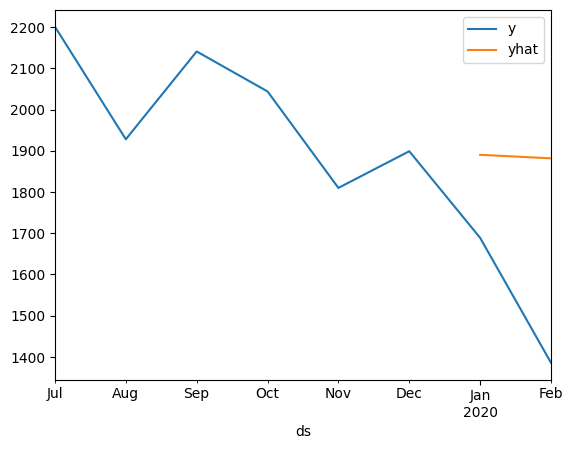

In [8]:
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")

# Verify you have 1 model and 1 forecast per unique ID.
assert len(model) == len(ID_LIST)
assert len(forecast) == len(ID_LIST)

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(ID_LIST[0:2]):
    display(forecast[p])
    future = pd.concat([train[p].set_index('ds')[[UNIQUE_ID, 'y']], forecast[p]])
    future[["y", "yhat"]].plot()

# Ray distributed Python

In [9]:
###########
# Convert existing functions to Ray remote functions
###########

# Convert your regular python functions to ray remote functions
train_model_arima_remote = ray.remote(train_model_arima).options(num_returns=3)  
inference_model_arima_remote = ray.remote(inference_model_arima).options(num_returns=2)

In [14]:
%%capture
# hide noisy output

###########
# Ray distributed program flow to train and inference ARIMA models
###########
model = []
train = []
valid = []
forecast_obj_refs = []

# Train every model.
start = time.time()
train_obj_refs, valid_obj_refs, model_obj_refs = map(
    list,
    zip(
        *(
            [
                train_model_arima_remote.remote(
                    # g_month,
                    input_data_ref,
                    input_value=v,
                )
                for v in ID_LIST
            ]
        )
    ),
)

# Inference every model.
error_obj_refs, forecast_obj_refs = map(
    list,
    zip(
        *(
            [
                inference_model_arima_remote.remote(model_obj_refs[p], valid_obj_refs[p] )
                for p in range(len(ID_LIST))
            ]
        )
    ),
)

# ray.get() means block until all objectIDs requested are available
forecast = ray.get(forecast_obj_refs)
error = ray.get(error_obj_refs)
train = ray.get(train_obj_refs)
model = ray.get(model_obj_refs)

# Print some training stats
time_ray_local = time.time() - start
# print(f"Total number of models: {len(model)}")
# print(f"TOTAL TIME TAKEN: {time_ray_local/60:.2f} minutes")

In [15]:
# Print some training stats
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_ray_local/60:.2f} minutes")

# Calculate speedup:
speedup = time_regular_python / time_ray_local
print(f"Speedup from running Ray parallel code on your laptop: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")


Total number of models: 0
TOTAL TIME TAKEN: 0.03 minutes
Speedup from running Ray parallel code on your laptop: 5.9x, or 500.0%


### Inspect a few forecasts

,unique_id,y,yhat
ds,,,
2020-01-31,1,34,52.351261
2020-02-29,1,35,51.710461


,unique_id,y,yhat
ds,,,
2020-01-31,10,1689,1890.360107
2020-02-29,10,1386,1881.759399


<Figure size 800x500 with 0 Axes>

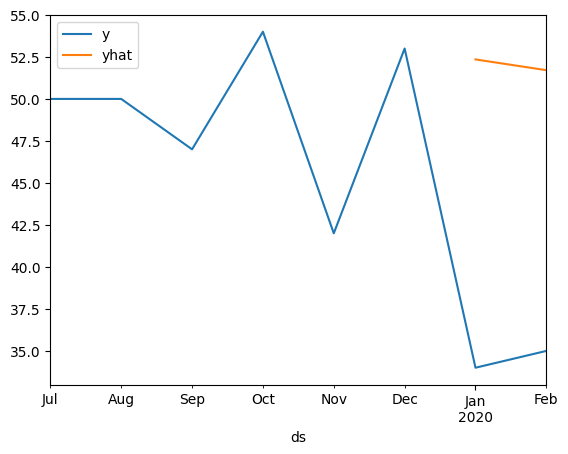

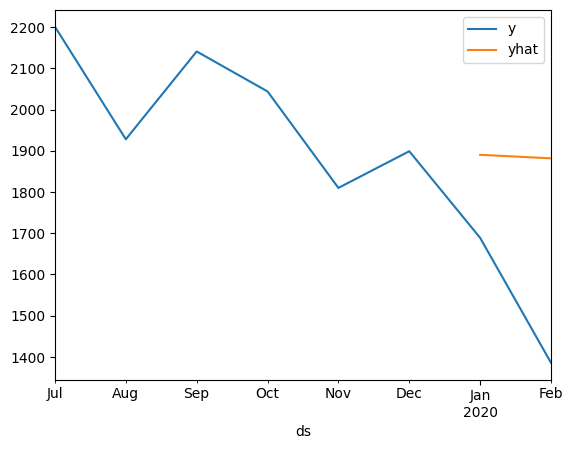

In [16]:
# Verify you have 1 model and 1 forecast per unique ID.
assert len(model) == len(ID_LIST)
assert len(forecast) == len(ID_LIST)

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(ID_LIST[0:2]):
    display(forecast[p])
    future = pd.concat([train[p].set_index('ds')[[UNIQUE_ID, 'y']], forecast[p]])
    future[["y", "yhat"]].plot()

In [18]:
import ray

if ray.is_initialized():
    ray.shutdown()